In [2]:
from mxnet import gluon, image, init, nd, autograd
from mxnet.gluon import model_zoo, nn
import time
import matplotlib.pyplot as plt
from IPython import display

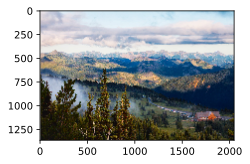

In [5]:
#使用'svg'矢量图显示图片
display.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = (3.5, 2.5)
content_img = image.imread('C:/Users/Administrator/DoDL/img/rainier.jpg')
plt.imshow(content_img.asnumpy())
plt.show()

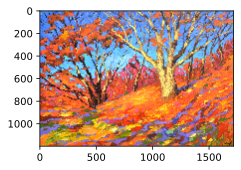

In [6]:
style_img = image.imread('C:/Users/Administrator/DoDL/img/autumn_oak.jpg')
plt.imshow(style_img.asnumpy())
plt.show()

预处理函数preprocess对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。
后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值。

In [8]:
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis=0)
def postprocess(img):
    img = img[0]
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)

In [12]:
#抽取特征，使用已训练好的网络来抽取
pretrained_net = model_zoo.vision.vgg19(pretrained=True)

In [13]:
#选择抽取风格特征和内容特征的层
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [14]:
#用到VGG从输入层到最靠近输出层的内容层或样式层之间的所有层构建一个新的网络net
net = nn.Sequential()
for i in range(max(style_layers + content_layers) + 1):
    net.add(pretrained_net.features[i])

In [15]:
#保留内容层及样式层的输出
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in content_layers:
            contents.append(X)
        if i in style_layers:
            styles.append(X)
    return contents, styles

In [16]:
#对内容图像抽取内容特征及对样式图像抽取样式特征
def get_content(image_shape):
    content_X = preprocess(content_img, image_shape)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_style(image_shape):
    style_X = preprocess(style_img, image_shape)
    _, style_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, style_Y

In [17]:
#定义内容损失函数以及样式损失函数
def content_loss(Y_hat, Y):
    return (Y_hat - Y).square().mean()

样式损失也一样通过平方误差函数衡量合成图像与样式图像在样式上的差异。为了表达样式层输出的样式，我们先通过extract_features函数计算样式层的输出。假设该输出的样本数为1，通道数为c，高和宽分别为h和w，我们可以把输出变换成c行hw列的矩阵X。矩阵X可以看作是由c个长度为hw的向量x1,…,xc组成的。其中向量xi代表了通道i上的样式特征。这些向量的格拉姆矩阵（Gram matrix）XX⊤∈Rc×c中i行j列的元素xij即向量xi与xj的内积，它表达了通道i和通道j上样式特征的相关性。我们用这样的格拉姆矩阵表达样式层输出的样式。需要注意的是，当hw的值较大时，格拉姆矩阵中的元素容易出现较大的值。此外，格拉姆矩阵的高和宽皆为通道数c。为了让样式损失不受这些值的大小影响，下面定义的gram函数将格拉姆矩阵除以了矩阵中元素的个数，即chw。

In [18]:
def gram(X):
    num_channels, n = X.shape[1], X.size // X.shape[1]
    X = X.reshape((num_channels, n))
    return nd.dot(X, X.T) / (num_channels * n)

In [19]:
def style_loss(Y_hat, gram_Y):
    return (gram(Y_hat) - gram_Y).square().mean()

我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。一种常用的降噪方法是总变差降噪（total variation denoising）。假设xi,j表示坐标为(i,j)

的像素值，降低总变差损失
∑i,j   |xi,j−xi+1,j|+|xi,j−xi,j+1|

能够尽可能使邻近的像素值相似。

In [21]:
def tv_loss(Y_hat):
    return 0.5 *((Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).abs().mean()
                + (Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).abs().mean())

样式迁移的损失函数即内容损失、样式损失和总变差损失的加权和。通过调节这些权值超参数，我们可以权衡合成图像在保留内容、迁移样式以及降噪三方面的相对重要性。

In [22]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def comput_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in 
                zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in
               zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l
    return contents_l, styles_l, tv_l,l

在样式迁移中，合成图像是唯一需要更新的变量。因此，我们可以定义一个简单的模型GeneratedImage，并将合成图像视为模型参数。模型的前向计算只需返回模型参数即可

In [23]:
class GeneratedImage(nn.Block):
    def __init__(self, image_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=image_shape)
    
    def forward(self):
        return self.weight.data()

我们定义get_inits函数。该函数创建了合成图像的模型实例，并将其初始化为图像X。样式图像在各个样式层的格拉姆矩阵styles_Y_gram将在训练前预先计算好。

In [24]:
def get_inits(X, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                           {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [25]:
def train(X, contents_Y, styles_Y, lr, max_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, lr, styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = comput_loss(X, contents_Y_hat,
                            styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        nd.waitall()
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, nd.add_n(*contents_l).asscalar(),
                     nd.add_n(*styles_l).asscalar(), tv_l.asscalar(),
                     time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
            print('change lr to %.1e' % trainer.learning_rate)
    return X

In [27]:
image_shape = (225, 150)
net.collect_params()
content_X, contents_Y = get_content(image_shape)
_, styles_Y = get_style(image_shape)
output = train(content_X, contents_Y, styles_Y, 0.01, 500, 200)

epoch  50, content loss 12.95, style loss 29.84, TV loss 3.53, 2.31 sec
epoch 100, content loss 9.50, style loss 15.76, TV loss 3.75, 2.27 sec
epoch 150, content loss 8.00, style loss 11.74, TV loss 3.86, 2.25 sec
epoch 200, content loss 7.16, style loss 9.36, TV loss 3.95, 2.22 sec
change lr to 1.0e-03
epoch 250, content loss 7.07, style loss 9.14, TV loss 3.96, 2.25 sec
epoch 300, content loss 6.99, style loss 8.95, TV loss 3.97, 2.22 sec
epoch 350, content loss 6.91, style loss 8.75, TV loss 3.98, 2.19 sec
epoch 400, content loss 6.83, style loss 8.55, TV loss 3.99, 2.30 sec
change lr to 1.0e-04
epoch 450, content loss 6.82, style loss 8.53, TV loss 3.99, 2.20 sec


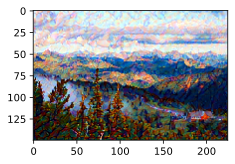

In [29]:
plt.imshow(postprocess(output).asnumpy())
plt.show()

epoch  50, content loss 13.78, style loss 12.92, TV loss 2.37, 9.67 sec
epoch 100, content loss 9.76, style loss 7.86, TV loss 2.60, 8.45 sec
change lr to 1.0e-03
epoch 150, content loss 9.45, style loss 7.61, TV loss 2.62, 8.72 sec
epoch 200, content loss 9.18, style loss 7.40, TV loss 2.63, 8.64 sec
change lr to 1.0e-04
epoch 250, content loss 9.15, style loss 7.37, TV loss 2.63, 8.56 sec


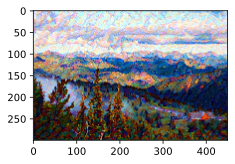

In [32]:
image_shape = (450, 300)
_, content_Y = get_content(image_shape)
_, style_Y = get_style(image_shape)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, 0.01, 300, 100)
plt.imshow(postprocess(output).asnumpy())
plt.show()